In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
import pandas as pd
from google.colab import drive
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Download and extract dataset
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
!tar -xvzf EnglishImg.tgz

# Path to the EnglishImg dataset
DATASET_PATH = "/content/English/Img"


Streaming output truncated to the last 5000 lines.
English/Img/GoodImg/Msk/Sample013/img013-00068.png
English/Img/GoodImg/Msk/Sample013/img013-00069.png
English/Img/GoodImg/Msk/Sample013/img013-00070.png
English/Img/GoodImg/Msk/Sample013/img013-00071.png
English/Img/GoodImg/Msk/Sample013/img013-00072.png
English/Img/GoodImg/Msk/Sample013/img013-00074.png
English/Img/GoodImg/Msk/Sample013/img013-00075.png
English/Img/GoodImg/Msk/Sample013/img013-00076.png
English/Img/GoodImg/Msk/Sample013/img013-00077.png
English/Img/GoodImg/Msk/Sample013/img013-00078.png
English/Img/GoodImg/Msk/Sample013/img013-00079.png
English/Img/GoodImg/Msk/Sample013/img013-00080.png
English/Img/GoodImg/Msk/Sample013/img013-00081.png
English/Img/GoodImg/Msk/Sample013/img013-00082.png
English/Img/GoodImg/Msk/Sample013/img013-00083.png
English/Img/GoodImg/Msk/Sample013/img013-00084.png
English/Img/GoodImg/Msk/Sample013/img013-00085.png
English/Img/GoodImg/Msk/Sample013/img013-00086.png
English/Img/GoodImg/Msk/Sample0

In [6]:
char_map = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')

def load_data(data_path, img_size=(28, 28)):
    images = []
    labels = []

    for root, dirs, files in os.walk(data_path):  # Recursively walk through directories
        if 'Msk' in root:  # Skip directories with 'Msk' in their name
            continue

        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Filter for image files
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)  # Read image

                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, img_size)  # Resize image
                    img = img.astype('float32') / 255.0  # Normalize pixel values

                    images.append(img)

                    # Extract label from the directory structure
                    sample_name = os.path.basename(root)
                    sample_index = int(sample_name.replace('Sample', '')) - 1  # Convert to 0-based index
                    label = char_map[sample_index]  # Get the character for that index
                    labels.append(label)

    return np.array(images), np.array(labels)

# Path to the dataset (adjust as needed)
dataset_path = "/content/English/Img"

# Load the data
X, y = load_data(dataset_path)

# Print the data statistics
print(f"Loaded {len(X)} images with {len(set(y))} unique labels.")
print("Dataset shape:", X.shape)  # Check dataset shape
print("Labels shape:", y.shape)

Loaded 12503 images with 62 unique labels.
Dataset shape: (12503, 28, 28)
Labels shape: (12503,)


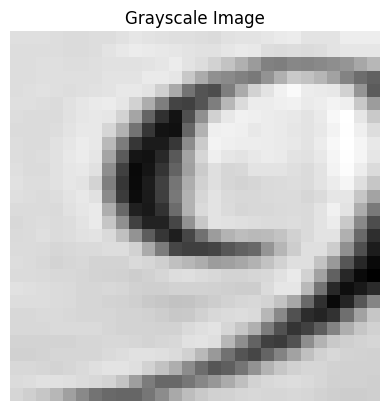

In [7]:
# Display the grayscale image
plt.imshow(X[1], cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

In [8]:
# Step 1: Select the 5 most frequent labels
label_counts = Counter(y)
most_common_labels = [label for label, count in label_counts.most_common(5)]
print(f"Most common labels: {most_common_labels}")


Most common labels: ['A', 'E', 'R', 'O', 'N']


In [9]:
# Step 2: Filter data to include only these 5 labels
mask = np.isin(y, most_common_labels)
X_filtered = X[mask]
y_filtered = y[mask]

In [10]:

# Step 3: Encode labels to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_filtered)

In [11]:
# Step 4: Flatten images to 1D arrays
X_flattened = np.array([image.flatten() for image in X_filtered])

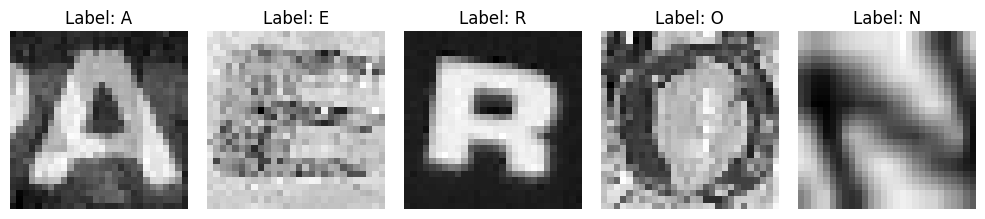

In [12]:
# Plot the first few images for each label
def plot_sample_images(X, y, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i, label in enumerate(labels):
        plt.subplot(5, 5, i + 1)
        idx = np.where(y == label)[0][0]  # Get an index for the label
        plt.imshow(X[idx],cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show sample images from the dataset
plot_sample_images(X_filtered, y_filtered, most_common_labels)

<ipython-input-13-ba1fd76e0158>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


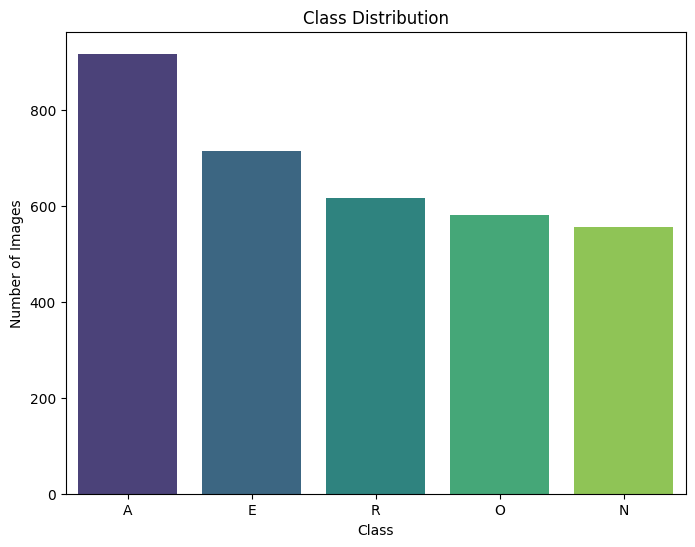

In [13]:
# Assuming y_train contains the class labels
class_counts = pd.Series(y_filtered).value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [14]:
# Step 5: Standardize the images
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)

# Step 6: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [15]:
# Step 7: Train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto', random_state=42)


In [16]:
# Store the history for plotting loss and accuracy curves
train_accuracies = []
train_losses = []

def plot_loss_accuracy_curve(model, X_train, y_train):
    # Fit model and track accuracy and loss
    model.fit(X_train, y_train)
    return model

logistic_model = plot_loss_accuracy_curve(logistic_model, X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [17]:
# Step 8: Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)


KNeighborsClassifier()

In [18]:
# Step 9: Make predictions with both models
y_pred_logistic = logistic_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

In [19]:
# Function to evaluate model
def evaluate_model(y_true, y_pred, model_name, model=None, X_test=None):
    print(f"--- {model_name} ---")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    lb = LabelBinarizer()
    lb.fit(y_true)  # Fit the LabelBinarizer on the true labels
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve and AUC - One-vs-Rest (OvR)
    y_true_bin = lb.transform(y_true)  # Transform true labels to one-hot encoding
    y_pred_prob = model.predict_proba(X_test) if model else None  # Get predicted probabilities for Logistic Regression or KNN

    if y_pred_prob is not None:  # Only calculate ROC for models with probability prediction (like Logistic Regression)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        n_classes = y_true_bin.shape[1]

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curve for each class
        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random model
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    return acc



--- Logistic Regression ---
Accuracy: 0.2684
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.38      0.34       173
           1       0.28      0.26      0.27       151
           2       0.22      0.19      0.20       117
           3       0.23      0.23      0.23       119
           4       0.27      0.25      0.26       118

    accuracy                           0.27       678
   macro avg       0.26      0.26      0.26       678
weighted avg       0.27      0.27      0.27       678



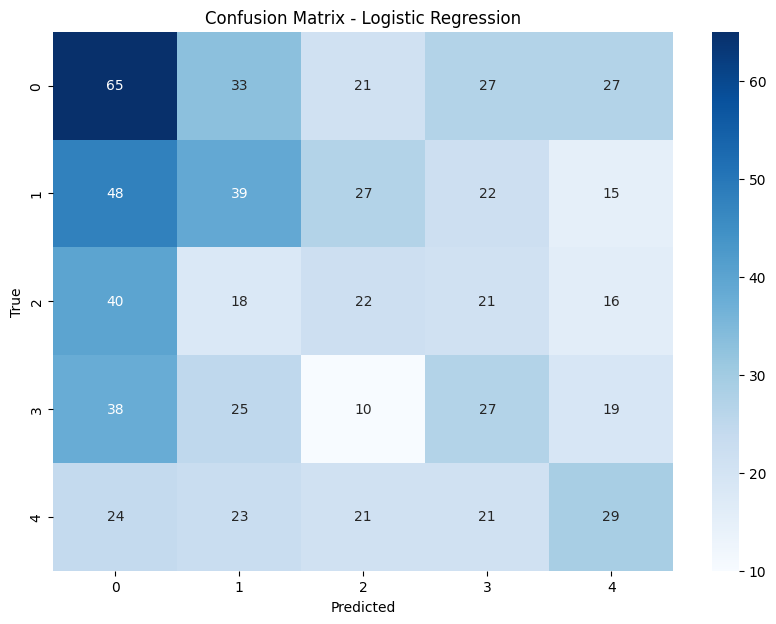

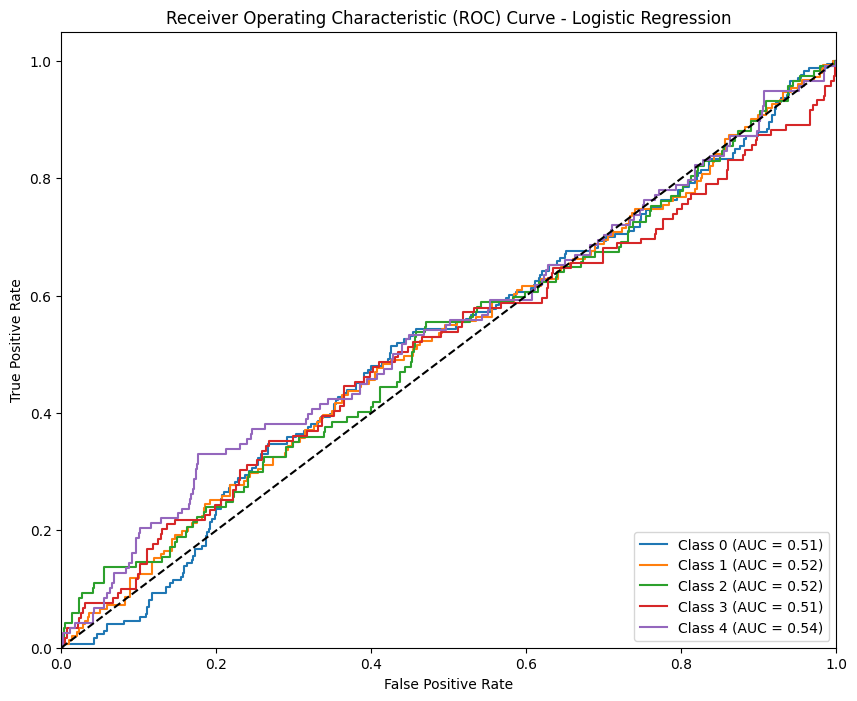

--- KNN ---
Accuracy: 0.8068
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.84       173
           1       0.75      0.83      0.79       151
           2       0.86      0.73      0.79       117
           3       0.91      0.82      0.86       119
           4       0.77      0.73      0.75       118

    accuracy                           0.81       678
   macro avg       0.82      0.80      0.80       678
weighted avg       0.81      0.81      0.81       678



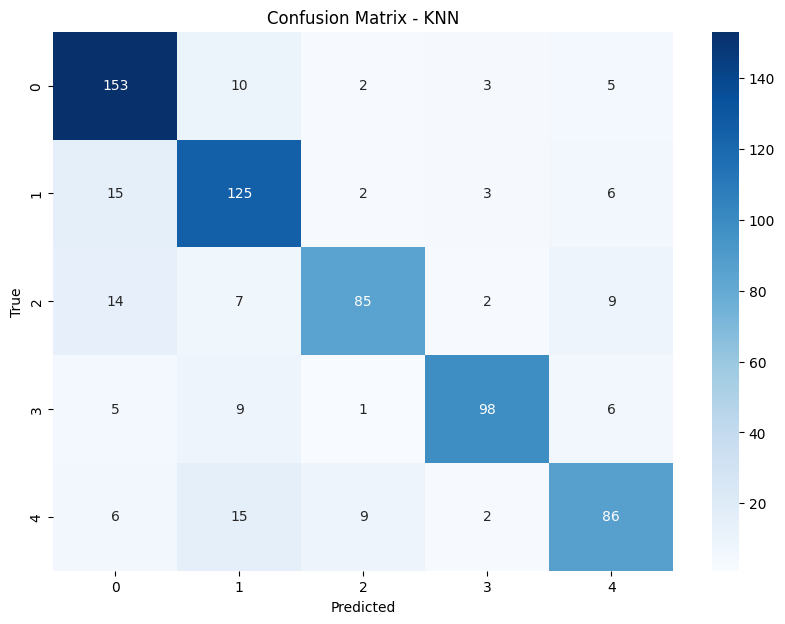

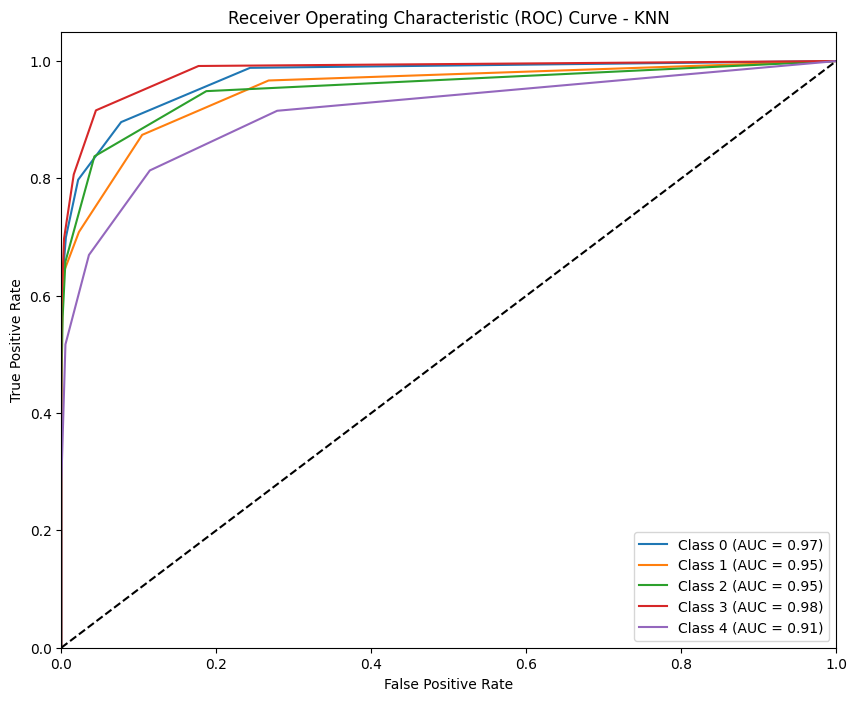

0.8067846607669616

In [20]:
# Step 12: Predictions for Logistic Regression
y_pred_logistic = logistic_model.predict(X_test)
evaluate_model(y_test, y_pred_logistic, "Logistic Regression", model=logistic_model, X_test=X_test)

# Step 13: Predictions for KNN
y_pred_knn = knn_model.predict(X_test)
evaluate_model(y_test, y_pred_knn, "KNN", model=knn_model, X_test=X_test)

Model Comparison:
KNN Loss: 1.6395, Accuracy: 0.8068
Logistic Regression Loss: 2.6308, Accuracy: 0.2684


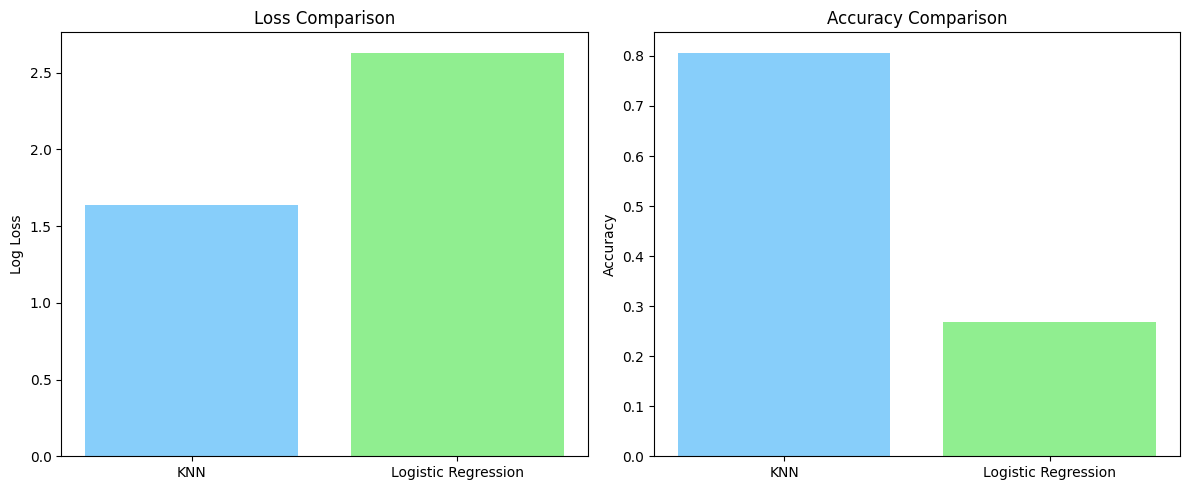

In [21]:

loss_values = []
accuracy_values = []
model_names = ['KNN', 'Logistic Regression']

# Calculate Loss and Accuracy for KNN
y_pred_knn_prob = knn_model.predict_proba(X_test)  # Use your correct KNN variable here
knn_loss = log_loss(y_test, y_pred_knn_prob)       # Logarithmic loss
knn_accuracy = accuracy_score(y_test, knn_model.predict(X_test))

# Append results
loss_values.append(knn_loss)
accuracy_values.append(knn_accuracy)

# Calculate Loss and Accuracy for Logistic Regression
y_pred_lr_prob = logistic_model.predict_proba(X_test)  # Use your correct Logistic Regression variable here
lr_loss = log_loss(y_test, y_pred_lr_prob)
lr_accuracy = accuracy_score(y_test, logistic_model.predict(X_test))

# Append results
loss_values.append(lr_loss)
accuracy_values.append(lr_accuracy)

# Print the Results
print("Model Comparison:")
print(f"KNN Loss: {knn_loss:.4f}, Accuracy: {knn_accuracy:.4f}")
print(f"Logistic Regression Loss: {lr_loss:.4f}, Accuracy: {lr_accuracy:.4f}")

# Visualization of Loss and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
ax[0].bar(model_names, loss_values, color=['#87CEFA', '#90EE90'])
ax[0].set_title('Loss Comparison')
ax[0].set_ylabel('Log Loss')

# Plot Accuracy
ax[1].bar(model_names, accuracy_values, color=['#87CEFA', '#90EE90'])
ax[1].set_title('Accuracy Comparison')
ax[1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


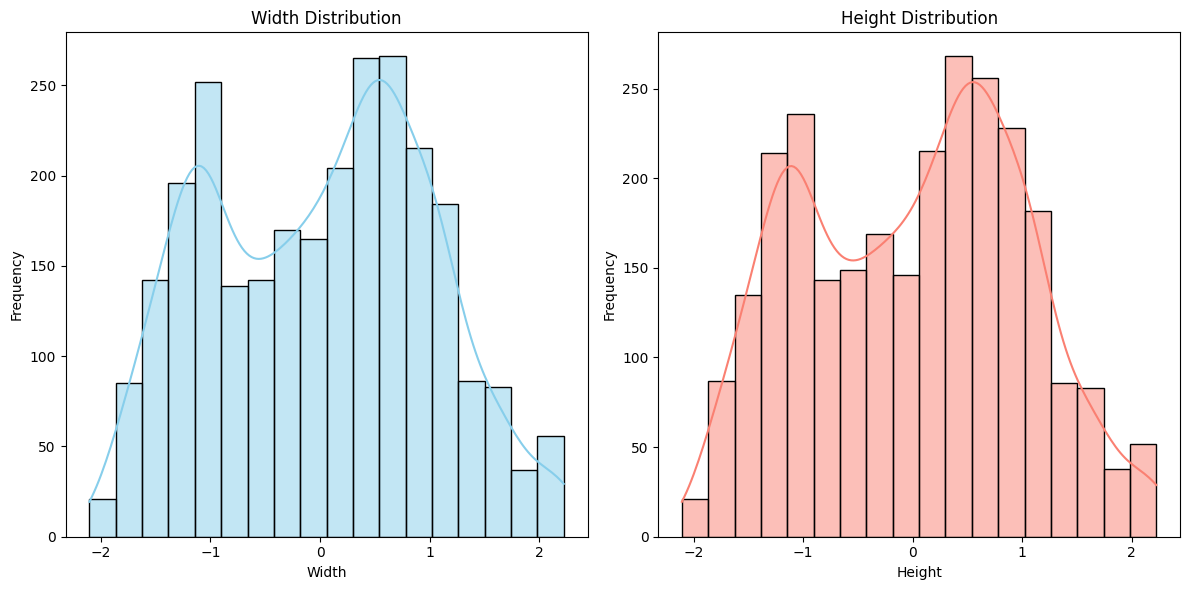

In [22]:
# Assuming X_train has two columns: width and height
widths = X_train[:, 0]  # First column is width
heights = X_train[:, 1]  # Second column is height

# Plot width and height distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True, color='skyblue')
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True, color='salmon')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Flattened image size: (28, 28)


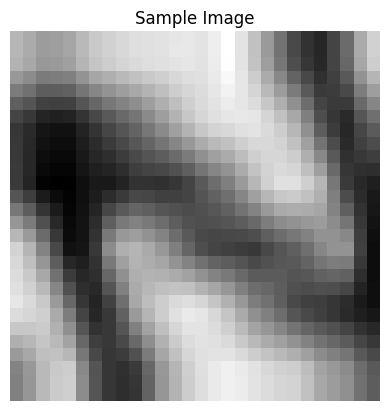

In [23]:
# Assuming the image is flattened (1D array), let's check its original size
sample_image_flattened = X_filtered[0]  # Example: take the first image from the dataset

# Check the size of the flattened image
print(f"Flattened image size: {sample_image_flattened.shape}")

# Reshape the flattened image to its original 2D shape (28x28 assumed)
# Resize the image to 28x28 if it's not of the right size
desired_image_size = (28, 28)

# If the original image is not of size (28, 28), resize it first
if sample_image_flattened.size != desired_image_size[0] * desired_image_size[1]:
    sample_image_resized = cv2.resize(sample_image_flattened, desired_image_size)
else:
    # Reshape the flattened image directly
    sample_image_resized = sample_image_flattened.reshape(desired_image_size)

# Plotting the sample image
plt.imshow(sample_image_resized, cmap='gray')  # Display in grayscale
plt.title("Sample Image")
plt.axis('off')  # Hide axes
plt.show()


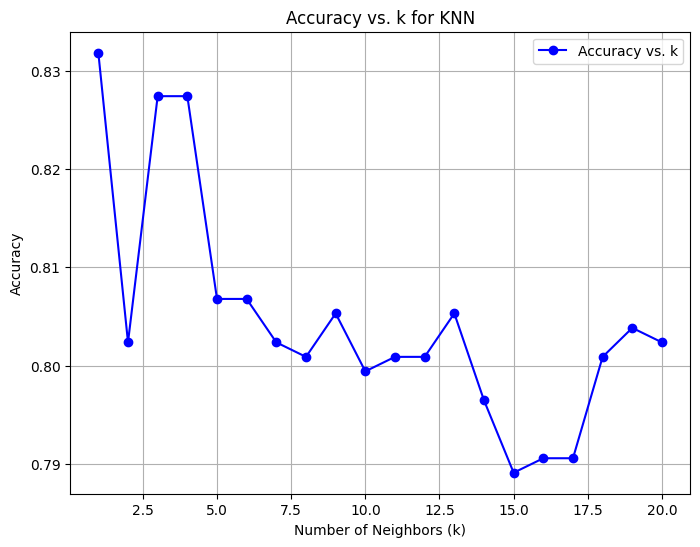

Best k: 1


In [24]:
# Plot accuracy vs. k
k_range = range(1, 21)
accuracies = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracies.append(knn.score(X_test, y_test))

plt.figure(figsize=(8, 6))
plt.plot(k_range, accuracies, marker='o', color='b', label='Accuracy vs. k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for KNN')
plt.legend()
plt.grid(True)
plt.show()

# Best k value
best_k = k_range[np.argmax(accuracies)]
print(f"Best k: {best_k}")
